In [1]:
import numpy as np
import skimage
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [27]:
def load_image(x):
    img=plt.imread(x)
    return img.astype(np.uint8)

def extraction(x,sx,sy):
    f = np.fft.fftshift(np.fft.fft2(x))
    (nx,ny) = np.shape(f)
#     sy=np.argmax(np.argmax(np.log(abs(f)), axis=1))
#     sx=np.argmax(np.log(abs(f[sy,:])))
    if sx is -1 or sy is -1:
        data = np.log2(abs(f))
        neighborhood_size=100
        threshold = 10
        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0
        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)

        x, y = [], []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2           
            y_center = (dy.start + dy.stop - 1)/2
            if x_center > 500 and x_center<520 and y_center>250 and y_center<800:
                x.append(x_center)
                y.append(y_center)
                     
        sx=int(x[0]-nx//8)
        sy=int(y[0]-ny//8)
    
    ex=int(sx+nx//4)    
    ey=int(sy+ny//4)
                 
    fp = np.zeros((nx//4,ny//4))  
    
    plt.imshow(np.log(abs(f[sy:ey,sx:ex])), cmap = 'gray')
#     plt.plot(x,y, 'ro')
    
    fp = np.fft.ifft2(np.fft.fftshift(f[sy:ey,sx:ex]))
#     plt.imshow(np.log(abs(wrap)), cmap = 'gray')
    return fp

def calcWrapPhase(bg, sp):
    field = np.zeros_like(sp).astype(np.complex64)
    field.real=np.arctan2(sp.imag, sp.real) - np.arctan2(bg.imag, bg.real)
    field.imag = np.sqrt(np.power(sp.real,2)+np.power(sp.imag,2))/np.sqrt(np.power(bg.real,2)+np.power(bg.imag,2))
    return field

from scipy.fftpack import dct, idct
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def unwrapping(x):
    phase = x
    (ny,nx) = np.shape(phase)
    dx = np.zeros((ny,nx))
    dy = np.zeros((ny,nx))
    dx[:,:-1] = np.diff(phase, axis=1)
    dy[:-1,:] = np.diff(phase, axis=0)
#     dx[:,-1] = -phase[:,-1]
#     dy[-1,:] = -phase[-1,:]
    
    dxp = dx - 2*np.pi*np.sign(dx)*np.floor(np.absolute(np.sign(dx)*np.pi+dx)/(2*np.pi))
    dyp = dy - 2*np.pi*np.sign(dy)*np.floor(np.absolute(np.sign(dy)*np.pi+dy)/(2*np.pi))
    
    sum_der = np.zeros((ny,nx), dtype=np.float32)
    
    tmp = np.zeros((ny,nx), dtype=np.float32)
    for j in range(0,ny):
        for i in range(0,nx):
            c1=0 if i is nx-1 else dxp[j,i]
            c2=0 if i is 0 else dxp[j,i-1]
            c3=0 if j is ny-1 else dyp[j,i]
            c4=0 if j is 0 else dyp[j-1,i]            
            sum_der[j,i] = (c1-c2)+(c3-c4)
            
            t = 2*np.cos((np.pi*4.0*i)/(4.0*nx))+2*np.cos((np.pi*4.0*j)/(4.0*ny))-4
            tmp[j, i] = t
    
#     Forward DCT
#     dst= scipy.fftpack.dct(scipy.fftpack.dct(sum_der, axis=1, norm="ortho").T,axis=1, norm="ortho").T
    dst = dct2(sum_der)
#     (3) Solve Possion problem
    phi=np.true_divide(dst, tmp, out=np.zeros_like(dst), where=tmp!=0)
    phi[0,0] = 0
#     Inverse DCT
#     phi= scipy.fftpack.idct(scipy.fftpack.idct(phi, axis=1, norm="ortho").T,axis=1, norm="ortho").T
    phi = idct2(phi)

    return phi
    
def plt_wrap(x):
    plt.imshow(x.real, cmap='gray')
    return 0

def phase_extraction(sp_path, bg_path):
    (sx,sy) = (-1,-1)
    sp = load_image(sp_path)
    bg = load_image(bg_path)
    field = calcWrapPhase(extraction(sp,sx,sy), extraction(bg,sx,sy))
    field.real = unwrapping(field.real)
    return field

In [41]:
from scipy.fftpack import dct, idct
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def unwrapping(x):
    phase = x
    (ny,nx) = np.shape(phase)
    dx = np.zeros((ny,nx))
    dy = np.zeros((ny,nx))
    dx[:,:-1] = np.diff(phase, axis=1)
    dy[:-1,:] = np.diff(phase, axis=0)
    
    dxp = dx - 2*np.pi*np.sign(dx)*np.floor(np.absolute(np.sign(dx)*np.pi+dx)/(2*np.pi))
    dyp = dy - 2*np.pi*np.sign(dy)*np.floor(np.absolute(np.sign(dy)*np.pi+dy)/(2*np.pi))
        
    sum_der = np.zeros((ny,nx), dtype=np.float32)    
#     sum_der[:,:-1] +=  np.diff(dxp, axis=1)
#     sum_der[:-1,:] +=  np.diff(dyp, axis=0)
    
    tmp = np.zeros((ny,nx), dtype=np.float32)
    for j in range(0,ny):
        for i in range(0,nx):     
            c1=0 if i is nx-1 else dxp[j,i]
            c2=0 if i is 0 else dxp[j,i-1]
            c3=0 if j is ny-1 else dyp[j,i]
            c4=0 if j is 0 else dyp[j-1,i]            
            sum_der[j,i] = (c1-c2)+(c3-c4)
            tmp[j, i] = 2*np.cos((np.pi*4.0*i)/(4.0*nx))+2*np.cos((np.pi*4.0*j)/(4.0*ny))-4             
    
#     Forward DCT
    dst = dct2(sum_der)
#     (3) Solve Possion problem
    phi=np.true_divide(dst, tmp, out=np.zeros_like(dst), where=tmp!=0)
#     Inverse DCT
    phi = idct2(phi)

    return phi

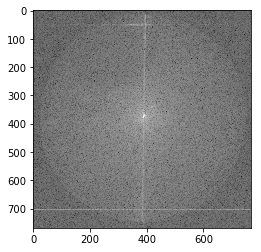

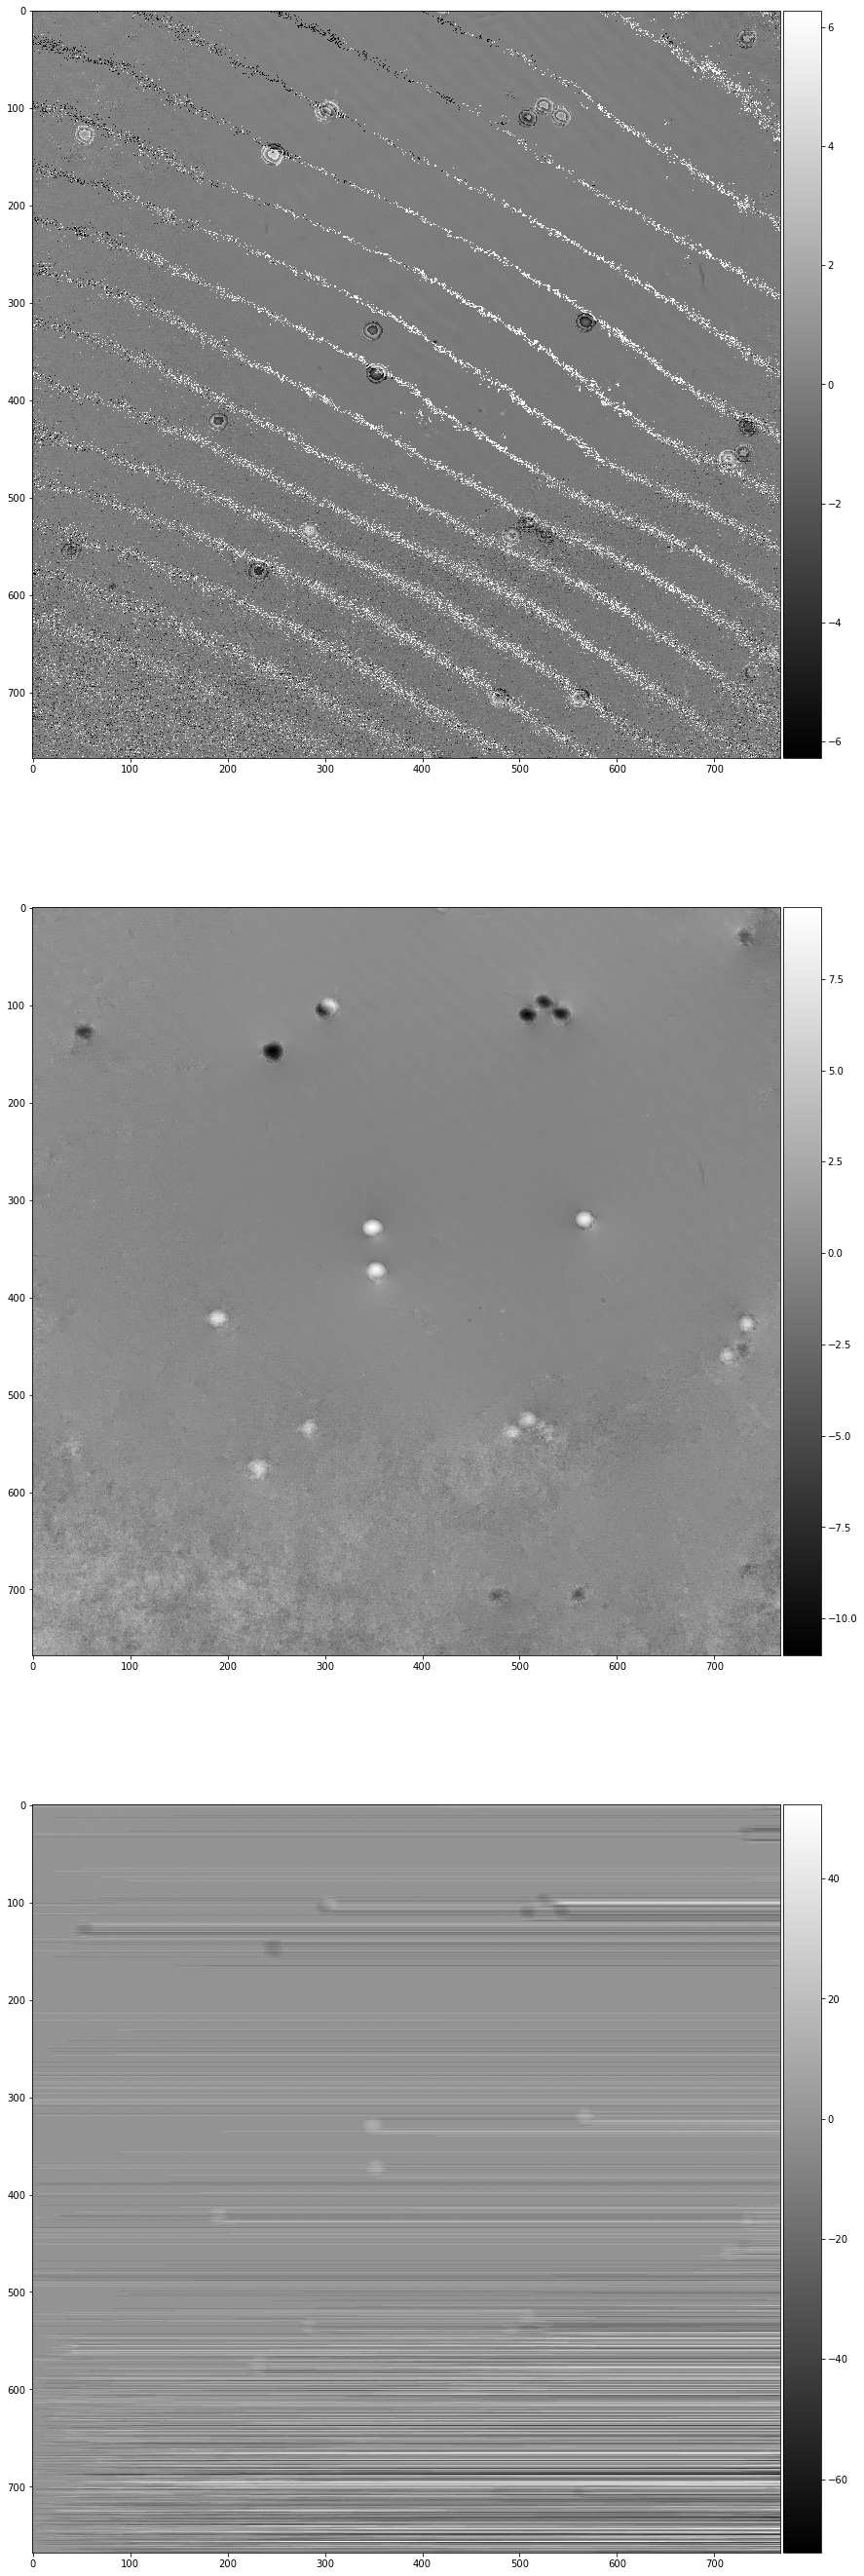

In [42]:
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import make_axes_locatable

# (sx,sy) = (-1,-1)
# sp_path ='/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer10.bmp'
# bg_path ='/media/share/MIC110/2019-08-21/Bead/1/BG/Buffer10.bmp'
(sx,sy) = (1166,66)
sp_path ='/media/share/MIC110/2020-08-01/Bead/1/SP/img_2020_08_01_10_52_33.bmp'
bg_path ='/media/share/MIC110/2020-08-01/Bead/1/SP/img_2020_08_01_10_52_48.bmp'

sp = load_image(sp_path)
bg = load_image(bg_path)
field = calcWrapPhase(extraction(bg,sx,sy), extraction(sp,sx,sy))
fig,axs =plt.subplots(nrows=3, ncols=1, figsize=(48,48))
im1 = axs[0].imshow(field.real,cmap='gray')
phi=unwrapping(field.real)
im2 = axs[1].imshow(phi,cmap='gray')
# im3 = axs[2].imshow(unwrap_phase(field.real),cmap='gray')
im3 = axs[2].imshow(np.unwrap(field.real),cmap='gray')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
plt.show()

/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer1.bmp


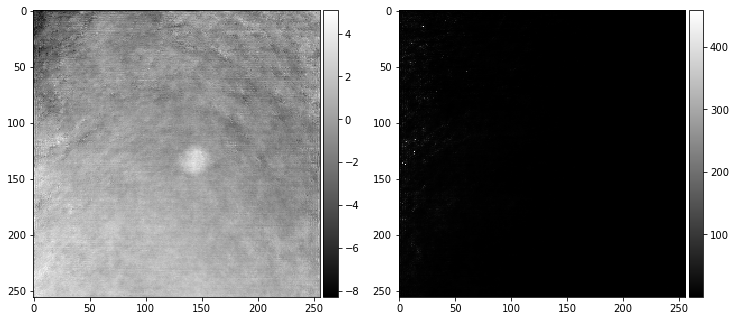

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer10.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer100.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer101.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer102.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer103.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer104.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer105.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer106.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer107.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer108.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer109.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer11.bmp
/media/share/MIC110/2019-08-21/Bead/1/SP/Buffer110.bmp


KeyboardInterrupt: 

In [4]:
import scipy.misc

SP = '/media/share/MIC110/2019-08-21/Bead/1/SP/'
BG = '/media/share/MIC110/2019-08-21/Bead/1/BG/'
ANG = '/media/share/MIC110/2019-08-21/Bead/1/Ang/'
SAVE = '/media/share/MIC110/2019-08-21/Bead/1/'
ext = '.bmp'

fig,axs =plt.subplots(nrows=1, ncols=2, figsize=(12,12))

for sp_file in tqdm(glob.glob(SP + '*' + ext)):
    filename = os.path.splitext(sp_file)[0].split('/')[-1]+ext
    bg_file = BG + filename
    ang_file = ANG + filename
    save_file = SAVE +filename
    
    if os.path.isfile(sp_file) is True and os.path.isfile(bg_file) is True and os.path.isfile(ang_file) is True:
        print(sp_file)
              
        field = phase_extraction(sp_file, bg_file)
        
        im1 = axs[0].imshow(field.real,cmap='gray')
        im2 = axs[1].imshow(field.imag,cmap='gray')
        
        divider = make_axes_locatable(axs[0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')

        divider = make_axes_locatable(axs[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        plt.show()
        
        scipy.misc.imsave(save_file, field.real)
        